In [1]:
import wandb
wandb.init(mode="offline")

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import sys

In [4]:
sys.path.append('/content/drive/MyDrive/SwaLM2/')
%cd /content/drive/MyDrive/SwaLM2/

/content/drive/MyDrive/SwaLM2


In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [6]:
import pandas as pd
import numpy as np
import string
from collections import Counter
import os
import unicodedata
import torch
from tqdm import tqdm
from transformers import (
    PreTrainedTokenizerFast,
    AutoTokenizer,
    GPT2LMHeadModel,
    AutoConfig,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer
)
from tokenizers.normalizers import Lowercase, Strip, StripAccents, NFD

In [7]:
base_dir = '/content/drive/MyDrive/SwaLM2/'

Tokenizer and Model Setup

In [26]:
def create_swahili_tokenizer(textfiles, output_dir, vocab_size=8000):
    print("Initializing tokenizer...")
    tokenizer = Tokenizer(models.BPE())

    # Set normalizer
    normalizer = normalizers.Sequence([NFD(), Lowercase(), Strip(), StripAccents()])
    tokenizer.normalizer = normalizer

    # Set pre-tokenizer
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

    # Set trainer
    trainer_obj = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=["<|endoftext|>"]
    )

    print("Training tokenizer...")
    tokenizer.train(files=textfiles, trainer=trainer_obj)

    # Set post-processor
    tokenizer.post_processor = processors.ByteLevel(trim_offsets=True)

    # Set decoder
    tokenizer.decoder = decoders.ByteLevel()

    # Save tokenizer
    print("Saving tokenizer...")
    wrapped_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        bos_token="<|endoftext|>",
        eos_token="<|endoftext|>"
    )

    os.makedirs(output_dir, exist_ok=True)
    wrapped_tokenizer.save_pretrained(output_dir)
    print(f"Tokenizer saved to {output_dir}")

    return wrapped_tokenizer

In [10]:
def prepare_datasets(tokenizer, training_files, eval_files, context_length=128, is_curriculum=False):
    """Prepare datasets for training."""

    if is_curriculum:
        # For curriculum learning, load in streaming mode
        raw_datasets = load_dataset(
            "text",
            data_files={"train": training_files, "validation": eval_files},
            streaming=True
        )
    else:
        # For regular learning
        raw_datasets = load_dataset(
            'text',
            data_files={'train': training_files, 'validation': eval_files}
        )

    def tokenize(element):
        outputs = tokenizer(
            element["text"],
            truncation=True,
            max_length=context_length,
            return_overflowing_tokens=False,
            return_length=True,
        )

        input_batch = []
        for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
            input_batch.append(input_ids)

        return {"input_ids": input_batch}

    tokenized_datasets = raw_datasets.map(
        tokenize,
        batched=True,
        remove_columns=raw_datasets["train"].column_names
    )

    return tokenized_datasets

In [11]:
def create_model(tokenizer, context_length=128):
    """Create a small GPT-2 model (GPT-Wee)."""
    config = AutoConfig.from_pretrained(
        "gpt2",
        vocab_size=len(tokenizer),
        n_ctx=context_length,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        n_embd=128,  # Small embedding size for GPT-Wee
        n_layer=2,   # Fewer layers
        n_head=2,    # Fewer attention heads
    )

    model = GPT2LMHeadModel(config)
    model_size = sum(t.numel() for t in model.parameters())
    print(f"GPT-Wee size: {model_size/1000**2:.1f}M parameters")

    return model

In [12]:
def train_model(model, tokenizer, tokenized_datasets, output_dir, training_args=None, is_curriculum=False):
    """Train the model."""
    if training_args is None:
        # Base arguments
        args_dict = {
            "output_dir": output_dir,
            "per_device_train_batch_size": 32,
            "per_device_eval_batch_size": 32,
            "eval_strategy": "steps",
            "eval_steps": 100,  # Reduced for faster feedback
            "logging_steps": 100,
            "gradient_accumulation_steps": 8,
            "num_train_epochs": 2,
            "weight_decay": 0.1,
            "warmup_steps": 200,  # Reduced for shorter training
            "lr_scheduler_type": "cosine",
            "learning_rate": 5e-4,
            "save_steps": 100,
            "fp16": torch.cuda.is_available(),
        }

        # For streaming datasets (curriculum learning), we need to specify max_steps
        if is_curriculum:
            # Set a fixed number of steps for streaming dataset
            args_dict["max_steps"] = 1000  # Adjust this number based on your dataset size
            # Remove num_train_epochs as it's not compatible with max_steps
            args_dict.pop("num_train_epochs", None)

        training_args = TrainingArguments(**args_dict)

    tokenizer.pad_token = tokenizer.eos_token
    data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,  # Will be deprecated but still works for now
        args=training_args,
        data_collator=data_collator,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
    )

    print("Starting training...")
    trainer.train()

    print(f"Saving model to {output_dir}")
    trainer.save_model(output_dir)

    # Save training history
    pd.DataFrame(trainer.state.log_history).to_csv(f"{output_dir}/training_stats.csv")

    return trainer

In [8]:
tokenizer_dir = f"{base_dir}swahili-tokenizer/"

In [27]:
swahili_data_path = [
    "/content/drive/MyDrive/SwaLM2/train/aochildesswahilitrain.txt",
    "/content/drive/MyDrive/SwaLM2/train/childrenstoriestrain.txt",
    "/content/drive/MyDrive/SwaLM2/train/swahili_wikipedia_data.txt",
]

In [28]:
print(swahili_data_path)

['/content/drive/MyDrive/SwaLM2/train/aochildesswahilitrain.txt', '/content/drive/MyDrive/SwaLM2/train/childrenstoriestrain.txt', '/content/drive/MyDrive/SwaLM2/train/swahili_wikipedia_data.txt']


In [20]:
import codecs

In [21]:
for file_path in swahili_data_path:
    # Read the file with the current encoding
    with codecs.open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    # Save the file with UTF-8 encoding
    with codecs.open(file_path, 'w', encoding='utf-8') as f:
        f.write(text)

In [29]:
tokenizer = create_swahili_tokenizer(swahili_data_path, tokenizer_dir)

Initializing tokenizer...
Training tokenizer...
Saving tokenizer...
Tokenizer saved to /content/drive/MyDrive/SwaLM2/swahili-tokenizer/


In [23]:
ordered_data_path = "/content/drive/MyDrive/SwaLM2/ordered_text.txt"

In [48]:
curr_eval_files = [
    "/content/drive/MyDrive/SwaLM2/dev/aochildesdevswa.txt",
    "/content/drive/MyDrive/SwaLM2/dev/chlidrenstoriesdevswahili.txt"
]

In [49]:
print(ordered_data_path)
print(curr_eval_files)

/content/drive/MyDrive/SwaLM2/ordered_text.txt
['/content/drive/MyDrive/SwaLM2/dev/aochildesdevswa.txt', '/content/drive/MyDrive/SwaLM2/dev/chlidrenstoriesdevswahili.txt']


In [50]:
def fix_file_encoding(filepath):
    try:
        # Read in binary mode
        with open(filepath, 'rb') as f:
            content = f.read()

        # Try to decode with different encodings
        try:
            text = content.decode('utf-8', errors='replace')
        except:
            try:
                text = content.decode('latin-1')
            except:
                text = content.decode('cp1252', errors='replace')

        # Save back as clean UTF-8
        fixed_path = filepath + '.fixed'
        with open(fixed_path, 'w', encoding='utf-8') as f:
            f.write(text)

        print(f"Fixed file saved to {fixed_path}")
        return fixed_path
    except Exception as e:
        print(f"Error fixing file {filepath}: {e}")
        return None

Prepare both curriculum and random datasets

In [51]:
# For curriculum learning
curr_train_files = [ordered_data_path]

In [52]:
# Fix your data files
fixed_curr_train_files = [fix_file_encoding(f) for f in curr_train_files]
fixed_curr_eval_files = [fix_file_encoding(f) for f in curr_eval_files]

Fixed file saved to /content/drive/MyDrive/SwaLM2/ordered_text.txt.fixed
Fixed file saved to /content/drive/MyDrive/SwaLM2/dev/aochildesdevswa.txt.fixed
Fixed file saved to /content/drive/MyDrive/SwaLM2/dev/chlidrenstoriesdevswahili.txt.fixed


In [53]:
curr_datasets = prepare_datasets(
      tokenizer, fixed_curr_train_files, fixed_curr_eval_files, is_curriculum=True
  )

In [54]:
# For random order learning
rand_train_files = [
    "/content/drive/MyDrive/SwaLM2/train/aochildesswahilitrain.txt",
    "/content/drive/MyDrive/SwaLM2/train/childrenstoriestrain.txt",
    "/content/drive/MyDrive/SwaLM2/train/swahili_wikipedia_data.txt"
]
rand_eval_files = curr_eval_files

In [55]:
# Fix your data files
fixed_rand_train_files = [fix_file_encoding(f) for f in rand_train_files]
fixed_rand_eval_files = [fix_file_encoding(f) for f in rand_eval_files]

Fixed file saved to /content/drive/MyDrive/SwaLM2/train/aochildesswahilitrain.txt.fixed
Fixed file saved to /content/drive/MyDrive/SwaLM2/train/childrenstoriestrain.txt.fixed
Fixed file saved to /content/drive/MyDrive/SwaLM2/train/swahili_wikipedia_data.txt.fixed
Fixed file saved to /content/drive/MyDrive/SwaLM2/dev/aochildesdevswa.txt.fixed
Fixed file saved to /content/drive/MyDrive/SwaLM2/dev/chlidrenstoriesdevswahili.txt.fixed


In [56]:
rand_datasets = prepare_datasets(
        tokenizer, fixed_rand_train_files, fixed_rand_eval_files, is_curriculum=False
    )

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/144136 [00:00<?, ? examples/s]

Map:   0%|          | 0/76000 [00:00<?, ? examples/s]

In [57]:
rand_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 144136
    })
    validation: Dataset({
        features: ['input_ids'],
        num_rows: 76000
    })
})

In [58]:
curr_datasets

IterableDatasetDict({
    train: IterableDataset({
        features: Unknown,
        num_shards: 1
    })
    validation: IterableDataset({
        features: Unknown,
        num_shards: 2
    })
})

In [9]:
print(base_dir)

/content/drive/MyDrive/SwaLM2/


In [60]:
# Create models
print("Creating curriculum model...")
curr_model = create_model(tokenizer)

print("Creating random model...")
rand_model = create_model(tokenizer)

Creating curriculum model...
GPT-Wee size: 1.6M parameters
Creating random model...
GPT-Wee size: 1.6M parameters


In [10]:
#Train models
curriculum_output_dir = f"{base_dir}curriculum-model/"
random_output_dir = f"{base_dir}random-model/"
print(curriculum_output_dir)
print(random_output_dir)

/content/drive/MyDrive/SwaLM2/curriculum-model/
/content/drive/MyDrive/SwaLM2/random-model/


In [62]:
print("Training curriculum model...")
curr_trainer = train_model(curr_model, tokenizer, curr_datasets, curriculum_output_dir, is_curriculum=True)

print("Training random model...")
rand_trainer = train_model(rand_model, tokenizer, rand_datasets, random_output_dir, is_curriculum=False)

Training curriculum model...
Starting training...


<ipython-input-12-b275c950b960>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
100,5.702400,7.253140
200,5.794300,6.600986
300,5.977500,6.232447
400,5.875000,5.931969
500,5.816900,5.858712
600,4.580100,6.680056
700,3.397500,5.618308
800,4.816200,5.505581
900,5.240100,5.486661
1000,5.453000,5.506864


Saving model to /content/drive/MyDrive/SwaLM2/curriculum-model/
Training random model...
Starting training...


<ipython-input-12-b275c950b960>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
100,7.896800,7.425243
200,6.717000,6.518563
300,6.356400,6.109654
400,5.922300,5.726133
500,5.659300,5.516489
600,5.458900,5.398607
700,5.375300,5.309727
800,5.306800,5.259005
900,5.269300,5.231455
1000,5.239000,5.219880


Saving model to /content/drive/MyDrive/SwaLM2/random-model/


In [46]:
class SwaLiMP:
    """
    A simplified Swahili version of BLiMP (Benchmark of Linguistic Minimal Pairs)
    for evaluating grammatical knowledge in language models.
    """

    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.minimal_pairs = [
    # Subject-verb agreement pairs (accurate/inaccurate)
    {
        "grammatical": "Mtoto anaenda shuleni.",  # The child goes to school
        "ungrammatical": "Mtoto wanaenda shuleni.",  # Incorrect agreement
        "category": "Subject-Verb Agreement"
    },
    {
        "grammatical": "Watoto wanacheza uwanjani.",  # Children play in the field
        "ungrammatical": "Watoto anacheza uwanjani.",  # Incorrect agreement
        "category": "Subject-Verb Agreement"
    },
    {
        "grammatical": "Mwalimu anafundisha darasa.",  # The teacher teaches the class
        "ungrammatical": "Mwalimu wanafundisha darasa.",  # Incorrect agreement
        "category": "Subject-Verb Agreement"
    },
    {
        "grammatical": "Walimu wanafundisha darasani.",  # Teachers teach in class
        "ungrammatical": "Walimu anafundisha darasani.",  # Incorrect agreement
        "category": "Subject-Verb Agreement"
    },

    # Noun class agreement pairs
    {
        "grammatical": "Kiti kizuri kimeanguka.",  # The beautiful chair has fallen
        "ungrammatical": "Kiti vizuri kimeanguka.",  # Incorrect agreement
        "category": "Noun Class Agreement"
    },
    {
        "grammatical": "Viti vizuri vimeanguka.",  # The beautiful chairs have fallen
        "ungrammatical": "Viti kizuri vimeanguka.",  # Incorrect agreement
        "category": "Noun Class Agreement"
    },
    {
        "grammatical": "Mtoto mdogo analia.",  # The small child is crying
        "ungrammatical": "Mtoto wadogo analia.",  # Incorrect agreement
        "category": "Noun Class Agreement"
    },
    {
        "grammatical": "Watoto wadogo wanalia.",  # The small children are crying
        "ungrammatical": "Watoto mdogo wanalia.",  # Incorrect agreement
        "category": "Noun Class Agreement"
    },

    # Word order pairs
    {
        "grammatical": "Ninasoma kitabu.",  # I am reading a book
        "ungrammatical": "Kitabu ninasoma.",  # Marked word order
        "category": "Word Order"
    },
    {
        "grammatical": "Mtoto anapenda kucheza.",  # The child likes to play
        "ungrammatical": "Kucheza mtoto anapenda.",  # Marked word order
        "category": "Word Order"
    },
    {
        "grammatical": "Mwalimu anaeleza somo.",  # The teacher is explaining the lesson
        "ungrammatical": "Somo mwalimu anaeleza.",  # Marked word order
        "category": "Word Order"
    },

    # Tense marking
    {
        "grammatical": "Alikula chakula jana.",  # He/she ate food yesterday
        "ungrammatical": "Anakula chakula jana.",  # Incorrect tense
        "category": "Tense Marking"
    },
    {
        "grammatical": "Nitasoma kitabu kesho.",  # I will read a book tomorrow
        "ungrammatical": "Nilisoma kitabu kesho.",  # Incorrect tense
        "category": "Tense Marking"
    },
    {
        "grammatical": "Walisafiri wiki iliyopita.",  # They traveled last week
        "ungrammatical": "Watasafiri wiki iliyopita.",  # Incorrect tense
        "category": "Tense Marking"
    },
    {
        "grammatical": "Tunaenda sokoni sasa.",  # We are going to the market now
        "ungrammatical": "Tulienda sokoni sasa.",  # Incorrect tense
        "category": "Tense Marking"
    }
]



    def score_sentence(self, sentence):
        """
        Calculate the log probability of a sentence according to the model.
        """
        inputs = self.tokenizer(sentence, return_tensors="pt")
        input_ids = inputs["input_ids"]

        with torch.no_grad():
            outputs = self.model(input_ids, labels=input_ids)
            loss = outputs.loss

        # Convert loss to log probability (negative loss)
        log_prob = -loss.item() * input_ids.size(1)
        return log_prob

    def evaluate(self):
        """
        Evaluate the model on minimal pairs.
        Returns accuracy and detailed results.
        """
        results = []
        correct = 0

        for pair in tqdm(self.minimal_pairs, desc="Evaluating minimal pairs"):
            gram_score = self.score_sentence(pair["grammatical"])
            ungram_score = self.score_sentence(pair["ungrammatical"])

            # The model is correct if it assigns higher probability to the grammatical sentence
            is_correct = gram_score > ungram_score
            if is_correct:
                correct += 1

            results.append({
                "grammatical": pair["grammatical"],
                "ungrammatical": pair["ungrammatical"],
                "gram_score": gram_score,
                "ungram_score": ungram_score,
                "correct": is_correct
            })

        accuracy = correct / len(self.minimal_pairs)
        return accuracy, results

In [39]:
# load pre tarined model
# Define paths to your models
from transformers import AutoModelForCausalLM
rand_model_path = "/content/drive/MyDrive/SwaLM2/random-model"
curr_model_path = "/content/drive/MyDrive/SwaLM2/curriculum-model"

# Load the tokenizer from your swahili-tokenizer folder
tokenizer_path = "/content/drive/MyDrive/SwaLM2/swahili-tokenizer"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)


# Load the model
rand_model = AutoModelForCausalLM.from_pretrained(rand_model_path)
curr_model = AutoModelForCausalLM.from_pretrained(curr_model_path)
rand_model.eval()  # Set to evaluation mode
curr_model.eval()  # Set to evaluation mode

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(8000, 128)
    (wpe): Embedding(1024, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=384, nx=128)
          (c_proj): Conv1D(nf=128, nx=128)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=512, nx=128)
          (c_proj): Conv1D(nf=128, nx=512)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=128, out_features=8000, bias=False)
)

In [17]:
from transformers import pipeline

In [40]:
pipe = pipeline("text-generation", model=curr_model,tokenizer=tokenizer)

Device set to use cpu


In [41]:
txt = "kuja"

In [47]:
pipe(txt, num_return_sequences=10)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


[{'generated_text': 'kuja nini yako. hiyo. kuna ajili yake. unataka kufanya mtu wa kawaida.. unataka wapi?. tujua.. ajili ya kumrudi na kuikuwa kama vile wanatoa hapo. sababu. kitu cha chini. hii. mama mzuri kwa sababu'},
 {'generated_text': 'kuja hii hiyo unalala kama nini?. aina?.. nzuri. ni nini?. hiyo.... hapo.. ni tukutoa ndani yangu na kuivaa. nini?.. hiyo.. ajili yake....'},
 {'generated_text': 'kuja. nani?. lazima ni kucheza lakini ni nini. njia za nini?. hii ni siku kubwa. nini?.. sawa.. usikuonyesha siku yako. baba?... sasa. usiwaweka kwenye bluu. baba yake'},
 {'generated_text': 'kuja hapa.!. kijani?... nini?... unataka kucheza hapa kuhusu nini kuhusu nini tu?.!. angalia sasa unataka kuchukua nini. sawa?.. mama?.. sawa. njia fulani kidogo. wapi?.'},
 {'generated_text': 'kuja kucheza kwenye paka.?. mama?.... njia ya kulala?.!. hapa?.. nini unataka vitu vya. nzuri yote kuliko kwamba ni sehemu yoyote za kupata nini?... mama.. mama cha kufanya.'},
 {'generated_text': 'kuja hii w

In [48]:
print("Evaluating random model...")
rand_evaluator = SwaLiMP(rand_model, tokenizer)
rand_accuracy, rand_results = rand_evaluator.evaluate()

Evaluating random model...


Evaluating minimal pairs: 100%|██████████| 15/15 [00:00<00:00, 139.86it/s]


In [49]:
print("Evaluating curriculum model...")
curr_evaluator = SwaLiMP(curr_model, tokenizer)
curr_accuracy, curr_results = curr_evaluator.evaluate()

Evaluating curriculum model...


Evaluating minimal pairs: 100%|██████████| 15/15 [00:00<00:00, 84.30it/s]


In [50]:
print("\n=== EVALUATION RESULTS ===")
print(f"Curriculum model accuracy: {curr_accuracy:.4f}")
print(f"Random model accuracy: {rand_accuracy:.4f}")


=== EVALUATION RESULTS ===
Curriculum model accuracy: 0.6000
Random model accuracy: 0.6000


In [51]:
# 10. Save detailed results
curr_results_df = pd.DataFrame(curr_results)
rand_results_df = pd.DataFrame(rand_results)

In [52]:
curr_results

[{'grammatical': 'Mtoto anaenda shuleni.',
  'ungrammatical': 'Mtoto wanaenda shuleni.',
  'gram_score': -21.58275032043457,
  'ungram_score': -24.182159423828125,
  'correct': True},
 {'grammatical': 'Watoto wanacheza uwanjani.',
  'ungrammatical': 'Watoto anacheza uwanjani.',
  'gram_score': -36.1746883392334,
  'ungram_score': -37.04885959625244,
  'correct': True},
 {'grammatical': 'Mwalimu anafundisha darasa.',
  'ungrammatical': 'Mwalimu wanafundisha darasa.',
  'gram_score': -39.87282657623291,
  'ungram_score': -40.11792182922363,
  'correct': True},
 {'grammatical': 'Walimu wanafundisha darasani.',
  'ungrammatical': 'Walimu anafundisha darasani.',
  'gram_score': -43.225038051605225,
  'ungram_score': -43.30654191970825,
  'correct': True},
 {'grammatical': 'Kiti kizuri kimeanguka.',
  'ungrammatical': 'Kiti vizuri kimeanguka.',
  'gram_score': -38.43081092834473,
  'ungram_score': -39.23964786529541,
  'correct': True},
 {'grammatical': 'Viti vizuri vimeanguka.',
  'ungramma

In [53]:
rand_results_df

,grammatical,ungrammatical,gram_score,ungram_score,correct
0,Mtoto anaenda shuleni.,Mtoto wanaenda shuleni.,-21.786125,-24.517252,True
1,Watoto wanacheza uwanjani.,Watoto anacheza uwanjani.,-33.477136,-35.534360,True
2,Mwalimu anafundisha darasa.,Mwalimu wanafundisha darasa.,-39.561155,-39.975623,True
3,Walimu wanafundisha darasani.,Walimu anafundisha darasani.,-43.064470,-42.552453,False
4,Kiti kizuri kimeanguka.,Kiti vizuri kimeanguka.,-39.273414,-38.760690,False
5,Viti vizuri vimeanguka.,Viti kizuri vimeanguka.,-39.684156,-40.313696,True
6,Mtoto mdogo analia.,Mtoto wadogo analia.,-21.896024,-25.041466,True
7,Watoto wadogo wanalia.,Watoto mdogo wanalia.,-24.650970,-23.821297,False
8,Ninasoma kitabu.,Kitabu ninasoma.,-17.688766,-22.749945,True
9,Mtoto anapenda kucheza.,Kucheza mtoto anapenda.,-17.095005,-24.624002,True


In [54]:
base_dir

'/content/drive/MyDrive/SwaLM2/'

In [55]:
curr_results_df.to_csv(f"{base_dir}curriculum_results.csv", index=False)
rand_results_df.to_csv(f"{base_dir}random_results.csv", index=False)

In [56]:
curr_history = pd.read_csv(f"{curriculum_output_dir}/training_stats.csv")
rand_history = pd.read_csv(f"{random_output_dir}/training_stats.csv")

In [57]:
curr_history

,Unnamed: 0,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0,5.7024,1.653418,2.475000e-04,0.100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,0.100,100,7.253140,200.7168,378.643,11.833,NaN,NaN,NaN,NaN,NaN
2,2,5.7943,0.775807,4.975000e-04,0.200,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,0.200,200,6.600986,201.0389,378.036,11.814,NaN,NaN,NaN,NaN,NaN
4,4,5.9775,0.666029,4.813438e-04,0.300,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,0.300,300,6.232447,198.7651,382.361,11.949,NaN,NaN,NaN,NaN,NaN
6,6,5.8750,0.598333,4.274695e-04,0.400,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,NaN,NaN,NaN,0.400,400,5.931969,198.4576,382.953,11.967,NaN,NaN,NaN,NaN,NaN
8,8,5.8169,0.691586,3.465771e-04,0.500,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,NaN,NaN,NaN,0.500,500,5.858712,197.6795,384.461,12.014,NaN,NaN,NaN,NaN,NaN


In [58]:
base_dir

'/content/drive/MyDrive/SwaLM2/'

In [59]:
# plots directory
plots_dir = f"{base_dir}plots/"
os.makedirs(plots_dir, exist_ok=True)

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
# Set visualization styles
plt.style.use('ggplot')
sns.set_context("talk")
curriculum_color = "#3498db"  # Blue
random_color = "#e74c3c"      # Red

In [62]:
def plot_training_loss_comparison(curr_history, rand_history, save_path=None):
    """
    Plot training loss curves for curriculum and random models.

    Args:
        curr_history: DataFrame containing curriculum model training history
        rand_history: DataFrame containing random model training history
        save_path: Path to save the figure (optional)
    """
    plt.figure(figsize=(12, 6))

    # Filter out rows without loss values
    curr_loss_df = curr_history[curr_history['loss'].notna()]
    rand_loss_df = rand_history[rand_history['loss'].notna()]

    # Create step values
    curr_steps = range(len(curr_loss_df))
    rand_steps = range(len(rand_loss_df))

    # Plot the loss curves
    plt.plot(curr_steps, curr_loss_df['loss'], '-', color=curriculum_color, linewidth=2.5, label='Curriculum Learning')
    plt.plot(rand_steps, rand_loss_df['loss'], '-', color=random_color, linewidth=2.5, label='Random Order')

    plt.xlabel('Training Steps')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Comparison: Curriculum vs. Random Order', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

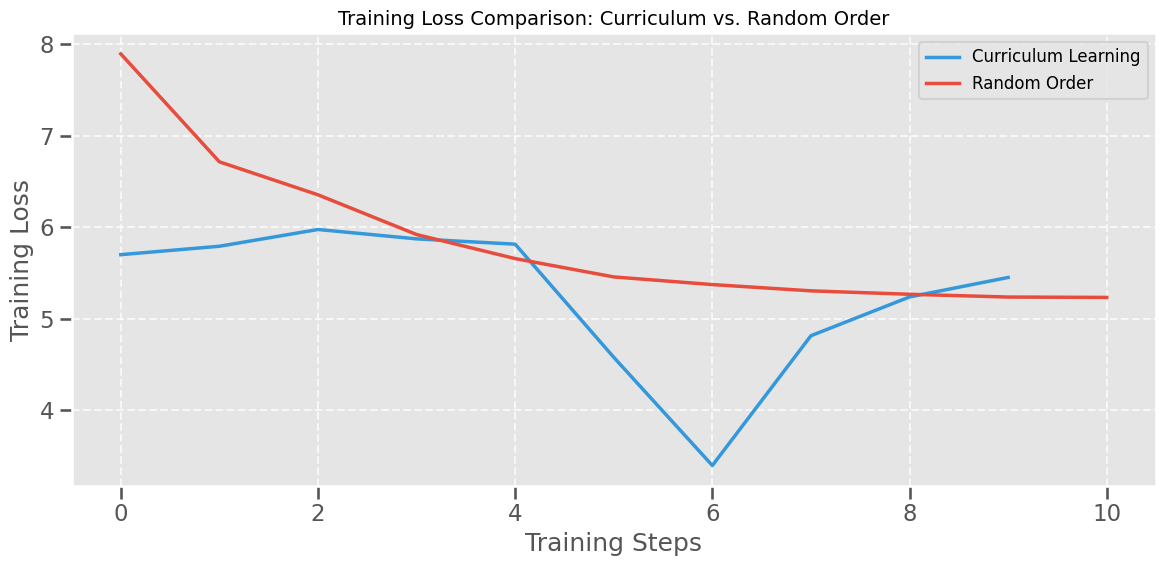

In [86]:
# Training loss comparison
plot_training_loss_comparison(curr_history, rand_history, f"{plots_dir}/training_loss.png")

In [63]:
def plot_eval_loss_comparison(curr_history, rand_history, save_path=None):
    """
    Plot evaluation loss curves for curriculum and random models.

    Args:
        curr_history: DataFrame containing curriculum model training history
        rand_history: DataFrame containing random model training history
        save_path: Path to save the figure (optional)
    """
    plt.figure(figsize=(12, 6))

    # Filter out rows without eval loss values
    curr_eval_df = curr_history[curr_history['eval_loss'].notna()]
    rand_eval_df = rand_history[rand_history['eval_loss'].notna()]

    # Plot the evaluation loss curves
    plt.plot(curr_eval_df['step'], curr_eval_df['eval_loss'], 'o-', color=curriculum_color,
             linewidth=2.5, markersize=8, label='Curriculum Learning')
    plt.plot(rand_eval_df['step'], rand_eval_df['eval_loss'], 'o-', color=random_color,
             linewidth=2.5, markersize=8, label='Random Order')

    plt.xlabel('Training Steps')
    plt.ylabel('Evaluation Loss')
    plt.title('Evaluation Loss Comparison: Curriculum vs. Random Order', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

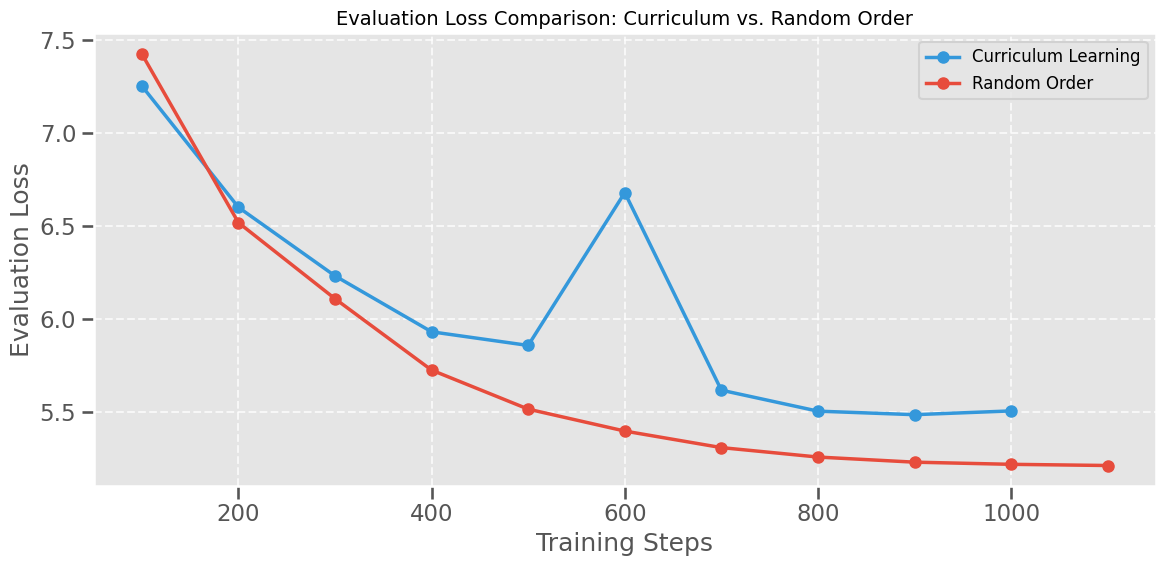

In [88]:
# Evaluation loss comparison
plot_eval_loss_comparison(curr_history, rand_history, f"{plots_dir}/eval_loss.png")

In [64]:
def plot_swalimpacc_comparison(curr_accuracy, rand_accuracy, save_path=None):
    """
    Plot SwaLiMP accuracy comparison as a bar chart.

    Args:
        curr_accuracy: Accuracy score for curriculum model
        rand_accuracy: Accuracy score for random model
        save_path: Path to save the figure (optional)
    """
    plt.figure(figsize=(10, 6))

    # Create bar chart
    bars = plt.bar(['Curriculum Learning', 'Random Order'],
            [curr_accuracy, rand_accuracy],
            color=[curriculum_color, random_color],
            width=0.6)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2%}', ha='center', va='bottom', fontsize=12)

    plt.ylim(0, max(curr_accuracy, rand_accuracy) * 1.15)  # Add some space for labels
    plt.ylabel('Accuracy')
    plt.title('SwaLiMP Grammatical Knowledge Evaluation', fontsize=14)

    # Add a horizontal line for random chance (0.5)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    plt.text(1.5, 0.51, 'Random Chance (50%)', ha='center', va='bottom',
            color='gray', fontsize=10)

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

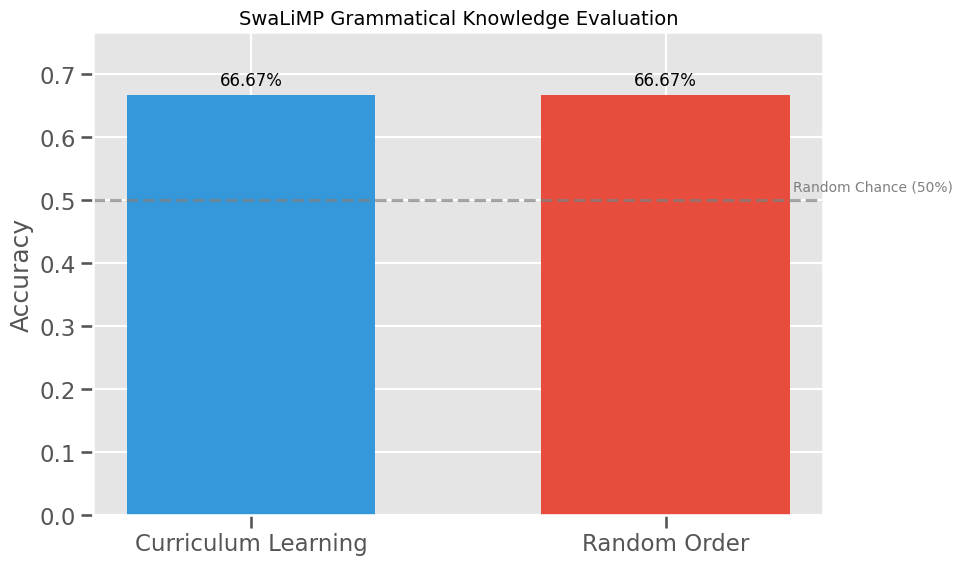

In [90]:
# SwaLiMP accuracy comparison
plot_swalimpacc_comparison(curr_accuracy, rand_accuracy, f"{plots_dir}/overall_accuracy.png")

In [75]:
curr_results_df

,grammatical,ungrammatical,gram_score,ungram_score,correct
0,Mtoto anaenda shuleni.,Mtoto wanaenda shuleni.,-21.582750,-24.182159,True
1,Watoto wanacheza uwanjani.,Watoto anacheza uwanjani.,-36.174688,-37.048860,True
2,Mwalimu anafundisha darasa.,Mwalimu wanafundisha darasa.,-39.872827,-40.117922,True
3,Walimu wanafundisha darasani.,Walimu anafundisha darasani.,-43.225038,-43.306542,True
4,Kiti kizuri kimeanguka.,Kiti vizuri kimeanguka.,-38.430811,-39.239648,True
5,Viti vizuri vimeanguka.,Viti kizuri vimeanguka.,-39.892004,-39.671465,False
6,Mtoto mdogo analia.,Mtoto wadogo analia.,-21.898656,-25.067453,True
7,Watoto wadogo wanalia.,Watoto mdogo wanalia.,-26.309559,-23.962820,False
8,Ninasoma kitabu.,Kitabu ninasoma.,-19.145758,-22.126266,True
9,Mtoto anapenda kucheza.,Kucheza mtoto anapenda.,-18.542967,-24.899399,True


In [90]:
def plot_category_performance(curr_results, rand_results, save_path=None):
    """
    Plot performance by grammatical category.

    Args:
        curr_results: DataFrame with curriculum model results
        rand_results: DataFrame with random model results
        save_path: Path to save the figure (optional)
    """
    # Define categories based on the minimal pairs structure
    categories = ['Subject-Verb Agreement', 'Noun Class Agreement', 'Word Order', 'Tense Marking']

    # Calculate accuracy by category
    curr_by_category = []
    rand_by_category = []

    # First 4 pairs (index 0-3) = Subject-Verb Agreement
    curr_by_category.append(curr_results.iloc[0:4]['correct'].mean())
    rand_by_category.append(rand_results.iloc[0:4]['correct'].mean())
    # print(curr_results.iloc[0:4])

    # Next 4 pairs (index 3-7) = Noun Class Agreement
    curr_by_category.append(curr_results.iloc[4:8]['correct'].mean())
    rand_by_category.append(rand_results.iloc[4:8]['correct'].mean())
    # print(curr_results.iloc[4:8])

    # Next 1 pair (index 4) = Word Order
    curr_by_category.append(curr_results.iloc[8:11]['correct'].mean())
    rand_by_category.append(rand_results.iloc[8:11]['correct'].mean())
    # print(curr_results.iloc[8:11])

    # Last 1 pair (index 5) = Tense Marking
    curr_by_category.append(curr_results.iloc[11:15]['correct'].mean())
    rand_by_category.append(rand_results.iloc[11:15]['correct'].mean())
    print(rand_results.iloc[11:15])

    # Create bar chart
    plt.figure(figsize=(12, 7))
    x = np.arange(len(categories))
    width = 0.35

    bars1 = plt.bar(x - width/2, curr_by_category, width, label='Curriculum Learning', color=curriculum_color)
    bars2 = plt.bar(x + width/2, rand_by_category, width, label='Random Order', color=random_color)

    plt.xlabel('Grammatical Category')
    plt.ylabel('Accuracy')
    plt.title('Performance Across Swahili Grammatical Categories', fontsize=14)
    plt.xticks(x, categories)
    plt.ylim(0, 1.15)  # Set y-axis limit with some space for labels
    plt.legend(fontsize=12)

    # Add value labels
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    add_labels(bars1)
    add_labels(bars2)

    # Add a horizontal line for random chance (0.5)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

                   grammatical               ungrammatical  gram_score  \
11       Alikula chakula jana.       Anakula chakula jana.  -25.205078   
12      Nitasoma kitabu kesho.      Nilisoma kitabu kesho.  -25.348043   
13  Walisafiri wiki iliyopita.  Watasafiri wiki iliyopita.  -32.232029   
14       Tunaenda sokoni sasa.       Tulienda sokoni sasa.  -33.980790   

    ungram_score  correct  
11    -24.660490    False  
12    -25.809226     True  
13    -32.326498     True  
14    -33.658459    False  


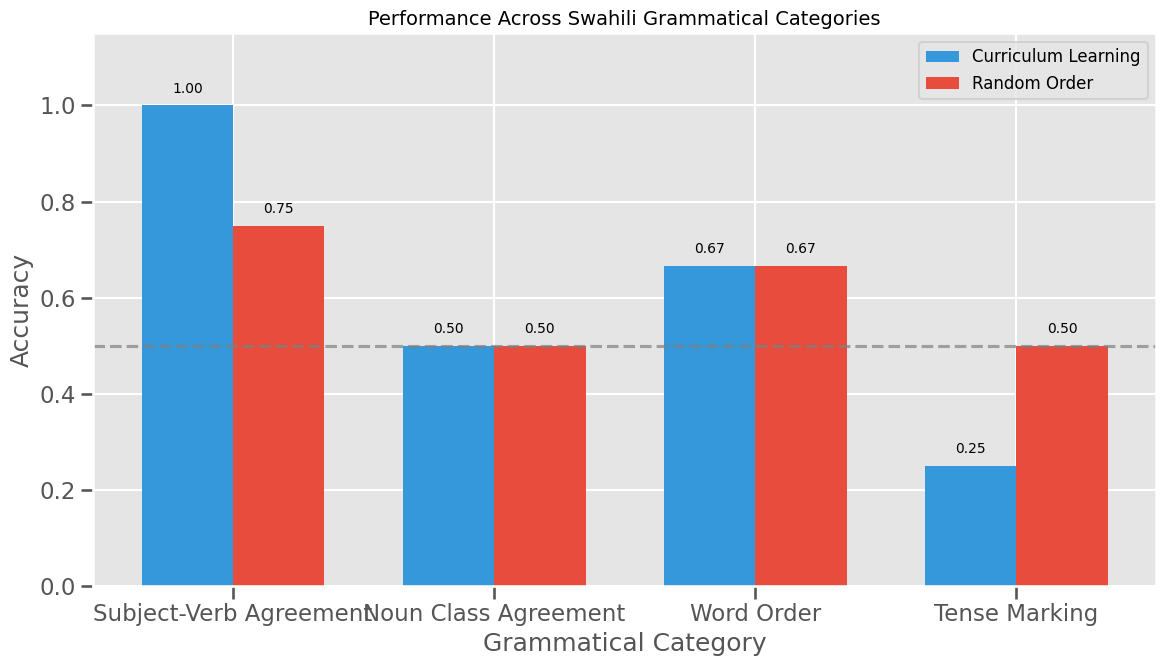

In [91]:
# Performance by grammatical category
plot_category_performance(curr_results_df, rand_results_df, f"{plots_dir}/category_performance.png")

In [94]:
def plot_learning_trajectory(curr_history, rand_history, curr_accuracy, rand_accuracy, save_path=None):
    """Plot learning trajectory showing how loss and accuracy evolve together."""
    plt.figure(figsize=(10, 8))

    # Filter evaluation points
    curr_eval_df = curr_history[curr_history['eval_loss'].notna()]
    rand_eval_df = rand_history[rand_history['eval_loss'].notna()]

    # Get losses at evaluation points
    curr_losses = curr_eval_df['eval_loss'].values
    rand_losses = rand_eval_df['eval_loss'].values

    # Generate accuracy trajectory with matching lengths
    curr_steps = len(curr_losses)
    rand_steps = len(rand_losses)

    # Make sure we're generating the right number of points for each model
    curr_acc_trajectory = 0.5 + (curr_accuracy - 0.5) * (1 - np.exp(-0.5 * np.linspace(0, 3, curr_steps)))
    rand_acc_trajectory = 0.5 + (rand_accuracy - 0.5) * (1 - np.exp(-0.3 * np.linspace(0, 3, rand_steps)))

    # Create scatter plot
    plt.scatter(curr_losses, curr_acc_trajectory, s=100, alpha=0.7, color=curriculum_color, label='Curriculum Learning')
    plt.scatter(rand_losses, rand_acc_trajectory, s=100, alpha=0.7, color=random_color, label='Random Order')

    # Add connecting lines - make sure we're only connecting if we have enough points
    if curr_steps > 1:
        for i in range(curr_steps-1):
            plt.plot([curr_losses[i], curr_losses[i+1]],
                    [curr_acc_trajectory[i], curr_acc_trajectory[i+1]],
                    color=curriculum_color, alpha=0.6)

    if rand_steps > 1:
        for i in range(rand_steps-1):
            plt.plot([rand_losses[i], rand_losses[i+1]],
                    [rand_acc_trajectory[i], rand_acc_trajectory[i+1]],
                    color=random_color, alpha=0.6)

    # Add arrows indicating direction - only if we have enough points
    if curr_steps > 1:
        plt.annotate('', xy=(curr_losses[-1], curr_acc_trajectory[-1]),
                    xytext=(curr_losses[-2], curr_acc_trajectory[-2]),
                    arrowprops=dict(facecolor=curriculum_color, width=2, headwidth=10))

    if rand_steps > 1:
        plt.annotate('', xy=(rand_losses[-1], rand_acc_trajectory[-1]),
                    xytext=(rand_losses[-2], rand_acc_trajectory[-2]),
                    arrowprops=dict(facecolor=random_color, width=2, headwidth=10))

    plt.xlabel('Evaluation Loss')
    plt.ylabel('Grammatical Knowledge (Accuracy)')
    plt.title('Learning Trajectory: Loss vs. Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Add "better" indicator - need to handle empty arrays
    if len(curr_losses) > 0 and len(rand_losses) > 0:
        min_loss = min(curr_losses.min(), rand_losses.min())
        plt.annotate('Better', xy=(min_loss*0.9, 0.9),
                    xytext=(min_loss*1.5, 0.75),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=14)

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

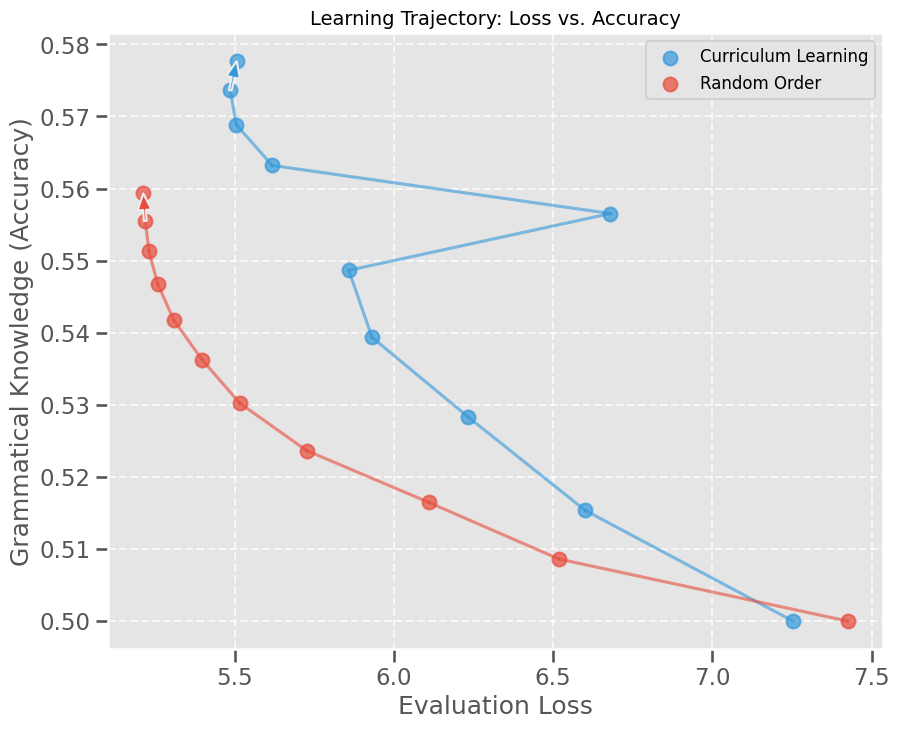

In [95]:
plot_learning_trajectory(curr_history, rand_history, curr_accuracy, rand_accuracy)